### TESTING 

In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import math
import os
import plotly.graph_objects as go

In [44]:
filename = 'all_combined_EMA2324M10139.csv'
df = pd.read_csv('data/'+filename)
df = df.dropna(subset='cycle_time')
# df = df.rename(columns={'CT': 'cycle_time', 'Shot Time': 'shot_time'})

In [49]:
df = df.dropna(subset='cycle_time')
df = df[['shot_time','cycle_time']]
data = ['cycle_time']
df['cycle_time'] = df['cycle_time'].apply(math.floor)
if_model = IsolationForest(contamination='auto',n_estimators=300,random_state=42,warm_start=True)
if_model.fit(df[data])
df['anomoly_score'] = if_model.decision_function(df[data])
df['anomoly_score_inverse']=if_model.score_samples(df[data])
# df['anomoly_score'] = df['anomoly_score']+1
df['anomoly_score_inverse'] = df['anomoly_score_inverse']+1
df['output'] = if_model.predict(df[data])

In [53]:
# Define a function to apply to each row
def assign_anomaly_score(row):
    if row['anomoly_score_inverse']<  0.3:
        return -1
    else:
        return 1

# Apply the function to create the new column
df['output_anomaly_score'] = df.apply(assign_anomaly_score, axis=1)

In [51]:
df.to_csv('result/'+filename)

### Useless Experimentation By Iftikhar

In [58]:
input_directory = "data"
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        try:
            file_path = os.path.join(input_directory, filename)
            df = pd.read_csv(file_path)
            df = df.dropna(subset='cycle_time')
            df = df[['shot_time','COUNTER_ID','cycle_time']]
            data = ['cycle_time']
            df['cycle_time'] = df['cycle_time'].apply(math.floor)
            if_model = IsolationForest(contamination='auto',n_estimators=300,random_state=42,warm_start=True)
            if_model.fit(df[data])
            df['anomoly_score'] = if_model.decision_function(df[data])
            df['anomoly_score_inverse']=if_model.score_samples(df[data])
            # df['anomoly_score'] = df['anomoly_score']+1
            df['anomoly_score_inverse'] = df['anomoly_score_inverse']+1
            df['output'] = if_model.predict(df[data])
            df.to_csv('result/'+filename)
        except Exception as e:
            print('Error => ',e)
            print('Error Processing file => ',filename)

Error =>  "['COUNTER_ID'] not in index"
Error Processing file =>  all_combined_EMA2233M10308.csv


C:\Users\uikra\AppData\Local\Temp\ipykernel_3056\846750267.py:6: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



In [87]:
def concatenate_dataframes(folder):
    # Initialize an empty list to store data frames
    dfs = []
    
    # Iterate through each file in the folder
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            # Read the CSV file and append it to the list
            df = pd.read_csv(os.path.join(folder, file))
            dfs.append(df)
    
    # Concatenate all data frames in the list along the rows
    concatenated_df = pd.concat(dfs, ignore_index=True)
    
    return concatenated_df

def merge_dataframes(folder1, folder2):
    # Concatenate data frames from each folder
    df1 = concatenate_dataframes(folder1)
    df2 = concatenate_dataframes(folder2)

    # Merge data frames on 'shot_time' and 'COUNTER_ID'
    merged_df = pd.merge(df1, df2, on=['shot_time', 'COUNTER_ID'], how='inner')

    return merged_df

# Replace 'folder1' and 'folder2' with the paths to your folders containing the data frames
folder1 = 'result'
folder2 = 'aist_result'

merged_dataframe = merge_dataframes(folder1, folder2)
merged_dataframe.rename(columns={'value2': 'aist'}, inplace=True)
merged_dataframe = merged_dataframe[['shot_time'	,'COUNTER_ID','output','aist']]
merged_dataframe = merged_dataframe.dropna()
merged_dataframe

,shot_time,COUNTER_ID,output,aist
0,2022-07-07 23:39:24,EMA2227A10005,1,0
1,2022-07-07 23:39:44,EMA2227A10005,1,0
2,2022-07-07 23:40:04,EMA2227A10005,1,0
3,2022-07-07 23:40:25,EMA2227A10005,1,0
4,2022-07-07 23:40:45,EMA2227A10005,1,0
...,...,...,...,...
808867,2023-11-27 13:48:19,EMA2324M10983,1,0
808868,2023-11-27 13:48:21,EMA2324M10983,1,2
808869,2023-11-27 13:48:29,EMA2324M10983,1,0
808870,2023-11-27 13:48:30,EMA2324M10983,1,2


In [88]:
merged_dataframe['aist'] = merged_dataframe['aist'].apply(lambda x: 0 if x == 2 else 1)
merged_dataframe['output'] = merged_dataframe['output'].replace({-1: 0})
merged_dataframe

,shot_time,COUNTER_ID,output,aist
0,2022-07-07 23:39:24,EMA2227A10005,1,1
1,2022-07-07 23:39:44,EMA2227A10005,1,1
2,2022-07-07 23:40:04,EMA2227A10005,1,1
3,2022-07-07 23:40:25,EMA2227A10005,1,1
4,2022-07-07 23:40:45,EMA2227A10005,1,1
...,...,...,...,...
808867,2023-11-27 13:48:19,EMA2324M10983,1,1
808868,2023-11-27 13:48:21,EMA2324M10983,1,0
808869,2023-11-27 13:48:29,EMA2324M10983,1,1
808870,2023-11-27 13:48:30,EMA2324M10983,1,0


In [90]:
from sklearn.metrics import confusion_matrix
# Ground truth
y_true = merged_dataframe['aist']
# Predicted labels
y_pred = merged_dataframe['output']
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 62210 166263]
 [ 40236 540163]]


In [92]:
# y_true 

y_pred 

0         1
1         1
2         1
3         1
4         1
         ..
808867    1
808868    1
808869    1
808870    1
808871    0
Name: output, Length: 808872, dtype: int64

In [91]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn)

# Calculate false negative rate (FNR)
fnr = fn / (fn + tp)

# Calculate sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Calculate specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Calculate positive predictive value (PPV) or precision
ppv = tp / (tp + fp)

# Calculate negative predictive value (NPV)
npv = tn / (tn + fn)

# Print the rates
print("False Positive Rate (FPR):", fpr)
print("False Negative Rate (FNR):", fnr)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Positive Predictive Value (PPV):", ppv)
print("Negative Predictive Value (NPV):", npv)


False Positive Rate (FPR): 0.7277139968398891
False Negative Rate (FNR): 0.0693247231645816
Sensitivity: 0.9306752768354184
Specificity: 0.2722860031601108
Positive Predictive Value (PPV): 0.7646420148748772
Negative Predictive Value (NPV): 0.6072467446264374


In [259]:
# df['gradient_fwd'] = df['cycle_time'].diff(1)
# df['gradient_bck'] = df['cycle_time'].diff(-1)

In [ ]:
df['gradient_bck'] = df['cycle_time'].diff(-1) # This will fill the first value with zero, because the difference is x = x[i] - x[i+1]
df['gradient_bck'] = df['gradient_bck'].abs()
df['gradient_fwd'] = df['cycle_time'].diff()
df['gradient_fwd'] = df['gradient_fwd'].abs()
tolerance = 5
df.loc[ (df['gradient_fwd'] >= tolerance) & (df['gradient_bck'] >= tolerance), 'output_anomaly_score'] = -1
df

### Isolation Forest on Concatenated Result (without hyper parameter tuning)

In [113]:
# Get list of files in folder
folder_path = 'data'  # Change this to your folder path
dfs = []  # List to hold DataFrames from each file
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(folder_path, filename)
        
        # Read CSV into DataFrame
        df = pd.read_csv(file_path)
        
        # Append DataFrame to list
        dfs.append(df)

# Concatenate all DataFrames in the list
combined_df = pd.concat(dfs, ignore_index=True)

# Drop rows with NaN values in 'cycle_time' column
combined_df = combined_df.dropna(subset=['cycle_time'])
combined_df.to_csv('combined_data.csv')
# Select only 'shot_time' and 'cycle_time' columns
combined_df = combined_df[['shot_time', 'cycle_time','COUNTER_ID']]

# Apply floor function to 'cycle_time' column
combined_df['cycle_time'] = combined_df['cycle_time'].apply(math.floor)

# Define features
data = ['cycle_time']

# Initialize Isolation Forest model
# if_model = IsolationForest(contamination='auto', random_state=42)
if_model = IsolationForest(contamination=0.1, random_state=42)


# Fit model
if_model.fit(combined_df[data])

# Calculate anomaly scores
combined_df['anomoly_score'] = if_model.decision_function(combined_df[data])
combined_df['anomoly_score_inverse'] = if_model.score_samples(combined_df[data])
combined_df['anomoly_score_inverse'] = combined_df['anomoly_score_inverse'] + 1

# Predict anomalies
combined_df['output'] = if_model.predict(combined_df[data])

# Apply the function to create the new column 'output_anomaly_score'
combined_df['output_anomaly_score'] = combined_df.apply(assign_anomaly_score, axis=1)
post_preprocessing = False
if post_preprocessing == True:
    combined_df['gradient_bck'] = combined_df['cycle_time'].diff(-1) # This will fill the first value with zero, because the difference is x = x[i] - x[i+1]
    combined_df['gradient_bck'] = combined_df['gradient_bck'].abs()
    combined_df['gradient_fwd'] = combined_df['cycle_time'].diff()
    combined_df['gradient_fwd'] = combined_df['gradient_fwd'].abs()

    tolerance = 5
    combined_df.loc[ (combined_df['gradient_fwd'] >= tolerance) & (combined_df['gradient_bck'] >= tolerance), 'output'] = -1

    threhold = 2
    combined_df.loc[ (combined_df['gradient_fwd'] <= threhold) & (combined_df['gradient_bck'] <= threhold), 'output'] = 1

# combined_df.loc[ (combined_df['gradient_fwd'] <= threhold) & (combined_df['gradient_bck'] <= threhold)& (combined_df['output'] == -1), 'output'] = 1
# Save result to a new CSV file
result_folder = 'result'  # Folder to save result
os.makedirs(result_folder, exist_ok=True)  # Create folder if it doesn't exist
result_file_path = os.path.join(result_folder, 'combined_result_iftihar.csv')
combined_df.to_csv(result_file_path, index=False)

C:\Users\uikra\AppData\Local\Temp\ipykernel_22772\3559514974.py:9: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



### Isolation Forest on Concatenated Result (with hyper parameter tuning)

In [ ]:
# Get list of files in folder
folder_path = 'data'  # Change this to your folder path
dfs = []  # List to hold DataFrames from each file
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(folder_path, filename)
        
        # Read CSV into DataFrame
        df = pd.read_csv(file_path)
        
        # Append DataFrame to list
        dfs.append(df)

# Concatenate all DataFrames in the list
combined_df = pd.concat(dfs, ignore_index=True)

# Drop rows with NaN values in 'cycle_time' column
combined_df = combined_df.dropna(subset=['cycle_time'])
combined_df.to_csv('combined_data.csv')
# Select only 'shot_time' and 'cycle_time' columns
combined_df = combined_df[['shot_time', 'cycle_time','COUNTER_ID']]

# Apply floor function to 'cycle_time' column
combined_df['cycle_time'] = combined_df['cycle_time'].apply(math.floor)

# Define features
data = ['cycle_time']
from tqdm import tqdm

grid_search_dict = {
    'cont_parm': [0.1, 0.2, 0.3, 0.4, 0.5, 'auto'],
    'n_estimators': [50, 100, 150, 200, 250, 300, 'auto'],
    'max_samples': [10, 20, 30, 40, 50, 60, 100, 150, 200, 'auto'],
    'max_features': [1, 0.5, 0.8, 1, 2, 3, 'auto'],
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

param_combinations = list(product(*grid_search_dict.values()))

for comb in tqdm(param_combinations, desc="Generating Files", unit="combination"):
    cont_parm, n_estimators, max_samples, max_features, bootstrap, warm_start = comb
    filename = f"combination_cont{cont_parm}_est{n_estimators}_samp{max_samples}_feat{max_features}_bootstrap{bootstrap}_warmstart{warm_start}"

    try:
 


        # Initialize Isolation Forest model
        # if_model = IsolationForest(contamination='auto', random_state=42)
        # if_model = IsolationForest(contamination=cont_parm, random_state=42)

        if_model = IsolationForest(n_estimators=n_estimators, 
                                   max_samples=max_samples, 
                                   contamination=cont_parm, 
                                   max_features=max_features,
                                    bootstrap=bootstrap, 
                                    random_state=12, 
                                    warm_start=warm_start)
        

        # Fit model
        if_model.fit(combined_df[data])

        # Calculate anomaly scores
        combined_df['anomoly_score'] = if_model.decision_function(combined_df[data])
        combined_df['anomoly_score_inverse'] = if_model.score_samples(combined_df[data])
        combined_df['anomoly_score_inverse'] = combined_df['anomoly_score_inverse'] + 1

        # Predict anomalies
        combined_df[f'output_{cont_parm}'] = if_model.predict(combined_df[data])

        # Apply the function to create the new column 'output_anomaly_score'
        combined_df[f'output_anomaly_score_{cont_parm}'] = combined_df.apply(assign_anomaly_score, axis=1)
        # combined_df.loc[ (combined_df['gradient_fwd'] <= threhold) & (combined_df['gradient_bck'] <= threhold)& (combined_df['output'] == -1), 'output'] = 1
        # Save result to a new CSV file
        result_folder = 'result'  # Folder to save result
        os.makedirs(result_folder, exist_ok=True)  # Create folder if it doesn't exist
        result_file_path = os.path.join(result_folder, f'{filename}.csv')
        combined_df.to_csv(result_file_path, index=False)
        # Perform garbage collection
        gc.collect()
        post_preprocessing = False
        if post_preprocessing == True:
            combined_df['gradient_bck'] = combined_df['cycle_time'].diff(-1) # This will fill the first value with zero, because the difference is x = x[i] - x[i+1]
            combined_df['gradient_bck'] = combined_df['gradient_bck'].abs()
            combined_df['gradient_fwd'] = combined_df['cycle_time'].diff()
            combined_df['gradient_fwd'] = combined_df['gradient_fwd'].abs()

            tolerance = 5
            combined_df.loc[ (combined_df['gradient_fwd'] >= tolerance) & (combined_df['gradient_bck'] >= tolerance), 'output'] = -1

            threhold = 2
            combined_df.loc[ (combined_df['gradient_fwd'] <= threhold) & (combined_df['gradient_bck'] <= threhold), 'output'] = 1


    except Exception as e:
        print(f'Failed filename : {filename}')
        print('Error ->',e)
        continue



### Iftikhar ki khushi

In [107]:
def calculate_differences(df, column_name):
    for i in range(1, 6):  # Calculate differences up to the fifth order
        # Forward differences
        df[f'diff_fwd_{i}'] = df[column_name].diff(periods=-i)
        df[f'diff_fwd_{i}'] = df[f'diff_fwd_{i}'].abs().round(2)

        # Backward differences
        df[f'diff_bck_{i}'] = df[column_name].diff(periods=i)
        df[f'diff_bck_{i}'] = df[f'diff_bck_{i}'].abs().round(2)

    return df

def create_forward_columns(df, n):
    for i in range(1, n+1):
        df[f'output_fwd_{i}'] = df['output'].shift(-i)
    return df

def create_backward_columns(df, n):
    for i in range(1, n+1):
        df[f'output_bck_{i}'] = df['output'].shift(i)
    return df

def create_five_shots(row):
    fwd_columns = [f'diff_fwd_{i}' for i in range(1, 6)]
    fwd_output_columns = [f'output_fwd_{i}' for i in range(1, 6)]
    bck_columns = [f'diff_bck_{i}' for i in range(1, 6)]
    bck_output_columns = [f'output_bck_{i}' for i in range(1, 6)]
    
    fwd_values = [(row[fwd_columns[i]], row[fwd_output_columns[i]]) for i in range(5)]
    bck_values = [(row[bck_columns[i]], row[bck_output_columns[i]]) for i in range(5)]
    
    return fwd_values + bck_values




In [ ]:
df= pd.read_csv('data/all_combined_EMA2227A10005.csv')
df = df.dropna(subset='cycle_time')
df = df[['shot_time','cycle_time']]
df['output'] = -1
df = calculate_differences(df, 'cycle_time')
df = create_feature_column(df)
df

In [108]:
folder_path = 'data'
dfs = [] 
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all DataFrames in the list
combined_df = pd.concat(dfs, ignore_index=True)

# Drop rows with NaN values in 'cycle_time' column
combined_df = combined_df.dropna(subset=['cycle_time'])

# Select only 'shot_time' and 'cycle_time' columns
combined_df = combined_df[['shot_time', 'cycle_time','COUNTER_ID']]

# Apply floor function to 'cycle_time' column
combined_df['cycle_time'] = combined_df['cycle_time'].apply(math.floor)

# Define features
data = ['cycle_time']

# Initialize Isolation Forest model
if_model = IsolationForest(contamination='auto', random_state=42)

# Fit model
if_model.fit(combined_df[data])

# Calculate anomaly scores
combined_df['anomoly_score'] = if_model.decision_function(combined_df[data])
combined_df['anomoly_score_inverse'] = if_model.score_samples(combined_df[data])
combined_df['anomoly_score_inverse'] = combined_df['anomoly_score_inverse'] + 1
# Predict anomalies
combined_df['output'] = if_model.predict(combined_df[data])
# Apply the function to create the new column 'output_anomaly_score'
combined_df['output_anomaly_score'] = combined_df.apply(assign_anomaly_score, axis=1)
combined_df = calculate_differences(combined_df, 'cycle_time')
tolerance = 5
combined_df.loc[ (combined_df['diff_fwd_1'] >= tolerance) & (combined_df['diff_bck_1'] >= tolerance), 'output'] = -1

threhold = 2
combined_df.loc[ (combined_df['diff_fwd_1'] <= threhold) & (combined_df['diff_bck_1'] <= threhold), 'output'] = 1

# Create forward columns
combined_df = create_forward_columns(combined_df, 5)
# Create backward columns
combined_df = create_backward_columns(combined_df, 5)

combined_df['five_shots'] = combined_df.apply(create_five_shots, axis=1)
result_folder = 'result'  # Folder to save result
os.makedirs(result_folder, exist_ok=True)  # Create folder if it doesn't exist
result_file_path = os.path.join(result_folder, 'combined_result.csv')
combined_df.to_csv(result_file_path, index=False)

C:\Users\uikra\AppData\Local\Temp\ipykernel_22772\3824538710.py:6: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



In [10]:
def process_file(file_path, output_directory,name):
    data = pd.read_csv(file_path)
    data['shot_time'] = pd.to_datetime(data['shot_time'])
    data = data.sort_values(by='shot_time')
    data = data.dropna(subset=['cycle_time'])
    # Group by COUNTER_ID
    grouped_data = data.groupby('COUNTER_ID')

    for counter_id, group_data in grouped_data:
        # Set color for markers based on output_anomaly_score column
        colors = ['red' if score == 2 else 'rgb(31, 119, 180)' for score in group_data['value2']]

        # Assuming 'cycle_time' and 'shot_time' are columns in your DataFrame
        hover_text = [f"Cycle Time: {ct}<br>Shot Time: {st}" 
                    for ct, st in zip(group_data['cycle_time'], group_data['shot_time'])]

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=group_data['shot_time'], y=group_data['cycle_time'], 
                                 mode='markers+lines', line=dict(color='darkgrey', width=1), 
                                 marker=dict(symbol='circle', size=8, color=colors),
                                #  hoverinfo='text'))
                                 hovertext=hover_text))

        fig.update_layout(
            title=f'Cycle Time vs Measurement Date - Counter ID: {counter_id}',
            xaxis_title='Measurement Date',
            yaxis_title='Cycle Time (seconds)',
            template='plotly_white',
            plot_bgcolor='lightgrey',
            xaxis=dict(
                showgrid=True,
                gridcolor='white',
                tickfont=dict(size=14) 
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='white',
                tickfont=dict(size=14)
            )
        )
        # Output file name based on counter_id
        filename = os.path.join(output_directory, f'{name+counter_id}_ct.html')
        fig.write_html(filename)

output_directory = "labelled_data_plot"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

input_directory = "Labelled_Data"
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        name =filename[:-4]
        print(name)
        file_path = os.path.join(input_directory, filename)
        process_file(file_path, output_directory,name)


EMA2233M10017_model_response
EMA2233M10024_model_response
EMA2233M10035_model_response
EMA2233M10100_model_response
EMA2233M10102_model_response
EMA2233M10103_model_response
EMA2303M10302_model_response


### Plots

In [52]:
def process_file(file_path, output_directory):
    data = pd.read_csv(file_path)
    data['shot_time'] = pd.to_datetime(data['shot_time'])
    data = data.dropna(subset=['cycle_time'])

    # Set color for markers based on output_anomaly_score column
    colors = ['red' if score == -1 else 'rgb(31, 119, 180)' for score in data['output']]

    # Add hover text with anomoly_score_inverse
    hover_text = [f"Cycle Time: {ct}<br>Anomaly Score Inverse: {score_inv}" 
                  for ct, score_inv in zip(data['cycle_time'], data['anomoly_score_inverse'])]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data['shot_time'], y=data['cycle_time'], 
                             mode='markers+lines', line=dict(color='darkgrey', width=1), 
                             marker=dict(symbol='circle', size=8, color=colors),
                             hoverinfo='text',
                             hovertext=hover_text))

    fig.update_layout(
        title='Cycle Time vs Measurement Date ',
        xaxis_title='Measurement Date',
        yaxis_title='Cycle Time (seconds)',
        template='plotly_white',
        plot_bgcolor='lightgrey',
        xaxis=dict(
            showgrid=True,
            gridcolor='white',
            tickfont=dict(size=14) 
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='white',
            tickfont=dict(size=14)
        )
    )

    # Assuming file_path and output_directory are defined
    filename = os.path.join(output_directory, '{}_ct.html'.format(os.path.basename(file_path).split('.')[0]))
    fig.write_html(filename)

output_directory = "ct_plots"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

input_directory = "result"
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_directory, filename)
        process_file(file_path, output_directory)


### Isolation forest results file by file (Auto-Mode) 

In [4]:
# Define the folder containing the files
folder_path = 'aist_resut_ver2_electrolux/'
result_path = 'if_results_electrolux'
# Create a folder to store the results if it doesn't exist
if not os.path.exists(result_path):
    os.makedirs(result_path)

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(folder_path, filename))
        # Drop NaN values and select relevant columns
        df = df.dropna(subset=['cycle_time'])
        df = df[['shot_time','COUNTER_ID', 'cycle_time']]
        df['cycle_time'] = df['cycle_time'].apply(math.floor)
        
        # Fit Isolation Forest model
        data = ['cycle_time']
        if_model = IsolationForest(contamination='auto', random_state=42, warm_start=True)
        if_model.fit(df[data])
        
        # Calculate anomaly scores
        df['anomoly_score'] = if_model.decision_function(df[data])
        df['anomoly_score_inverse'] = if_model.score_samples(df[data])
        df['anomoly_score_inverse'] = df['anomoly_score_inverse'] + 1
        # Predict anomalies and assign anomaly scores
        df['output'] = if_model.predict(df[data])
        df['output'] = df['output'].apply(lambda x: 0 if x == -1 else 1)
        df['output'] = 1 - df['output']

        # Save the results in a new CSV file
        result_filename = os.path.join(result_path, filename)
        df.to_csv(result_filename, index=False)
        print(f"----------- {filename} complete -----------")


----------- EMA2233M10295_model_response.csv complete -----------
----------- EMA2233M10296_model_response.csv complete -----------
----------- EMA2233M10297_model_response.csv complete -----------
----------- EMA2233M10300_model_response.csv complete -----------
----------- EMA2233M10302_model_response.csv complete -----------
----------- EMA2233M10303_model_response.csv complete -----------
----------- EMA2233M10304_model_response.csv complete -----------
----------- EMA2233M10305_model_response.csv complete -----------
----------- EMA2233M10308_model_response.csv complete -----------


### New Approach for finding best hyper parameters for Isolation forest
==> It involves comparing ground truth against different results obtained, the best parameter would be the one with less false positives.

In [23]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm

In [7]:
def compare_with_ground_truth(predictions, ground_truth):
    ground_truth = ground_truth.astype(int)
    predictions = predictions.astype(int)
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(ground_truth, predictions)
    # Calculate false positive and false negative rates
    false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    return false_positive_rate,false_negative_rate,conf_matrix

In [8]:
def combine_dataframes(folder_path):
    combined_df = pd.DataFrame() 
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            combined_df = pd.concat([combined_df, df])
    return combined_df

In [26]:
# Define folder path
folder_path = "Labelled_Data/"
results_df = pd.DataFrame(columns=['File', 'Best Parameters', 'Best Score'])
# Iterate over files in the folder
combined_df = combine_dataframes(folder_path)

# Load ground truth DataFrame
combined_df = combined_df[['shot_time', 'COUNTER_ID', 'cycle_time', 'value2']]
# ground_truth = ground_truth[['shot_time', 'COUNTER_ID', 'cycle_time', 'value2']]
combined_df.rename(columns={'value2': 'ground_truth'}, inplace=True)
combined_df['ground_truth'] = combined_df['ground_truth'].apply(lambda x: 0 if x == 2 else 1)
combined_df['ground_truth'] = 1 - combined_df['ground_truth'] # Inverting it for clarity 1 means anomaly and 0 means normal (1 is positive class and 0 is negative class)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_samples': ['auto',0.1,0.2,0.3,0.4,0.5],
    'contamination': ['auto', 0.1,0.2,0.3,0.4,0.5],
    'max_features': [1.0,0.1,0.2,0.3,0.4,0.5],
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

# param
best_params_fpr = None
best_params_fnr = None
best_params_fnr_combined = None

# score
best_score_fnr =  float('inf')
best_score_fpr =  float('inf')
best_score_fnr_combined =  float('inf')
best_score_fpr_combined =  float('inf')

# confusion metrix
conf_matrix_fnr =  None
conf_matrix_fpr =  None
conf_matrix_combined =  None

total_iterations = len(list(ParameterGrid(param_grid)))
with tqdm(total=total_iterations, desc="Hyperparameter Tuning") as pbar:
    for params in ParameterGrid(param_grid):
        # Create Isolation Forest model
        if_model = IsolationForest(**params, random_state=12)
        data = ['cycle_time']
        # Fit model
        if_model.fit(combined_df[data])

        # Calculate anomaly scores
        combined_df['anomaly_score'] = if_model.decision_function(combined_df[data])
        combined_df['anomaly_score_inverse'] = if_model.score_samples(combined_df[data])

        # Predict anomalies
        combined_df[f'output'] = if_model.predict(combined_df[data])
        combined_df[f'output'] = combined_df[f'output'].apply(lambda x: 0 if x == -1 else 1)
        combined_df[f'output'] = 1 - combined_df[f'output'] # Inverting it for clarity 1 means anomaly and 0 means normal (1 is positive class and 0 is negative class)

        # Compare results with ground truth
        fpr,fnr, cm = compare_with_ground_truth(combined_df[f'output'], combined_df['ground_truth'])

        # Update best parameters if necessary
        if fpr < best_score_fpr:
            best_params_fpr = params
            conf_matrix_fpr = cm
            best_score_fpr =fpr
        
        if fnr < best_score_fnr:
            best_params_fnr = params
            conf_matrix_fnr = cm
            best_score_fnr = fnr


        if fpr < best_score_fpr_combined and fnr < best_score_fnr_combined:
            best_score_fpr = fpr
            best_score_fnr = fnr
            best_params_fnr_combined = params
            conf_matrix_combined = cm
            best_score_fnr_combined = fnr
            best_score_fpr_combined = fpr

        pbar.update(1)  # Update progress bar
# Print all best parameters and scores
print("Best parameters for FPR:", best_params_fpr)
print("Best score FPR:", best_score_fpr)
print("Confusion Matrix FPR:", conf_matrix_fpr)

print("Best parameters for FNR:", best_params_fnr)
print("Best score FNR:", best_score_fnr)
print("Confusion Matrix FNR:", conf_matrix_fnr)

print("Best parameters for Combined FPR and FNR:", best_params_fnr_combined)
print("Best score Combined FPR:", best_score_fnr_combined)
print("Best score Combined FPR:", best_score_fpr_combined)
print("Confusion Matrix Combined:", conf_matrix_combined)

Hyperparameter Tuning: 100%|██████████| 4320/4320 [57:01<00:00,  1.26it/s]  

Best parameters for FPR: {'bootstrap': True, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 0.4, 'n_estimators': 100, 'warm_start': True}
Best score FPR: 0.009277103034105678
Confusion Matrix FPR: [[22106   207]
 [   16   183]]
Best parameters for FNR: {'bootstrap': True, 'contamination': 0.4, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'warm_start': True}
Best score FNR: 0.010050251256281407
Confusion Matrix FNR: [[13758  8555]
 [    2   197]]
Best parameters for Combined FPR and FNR: {'bootstrap': True, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 0.1, 'n_estimators': 50, 'warm_start': True}
Best score Combined FPR: 0.07035175879396985
Best score Combined FPR: 0.03948370904853673
Confusion Matrix Combined: [[21432   881]
 [   14   185]]


In [27]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

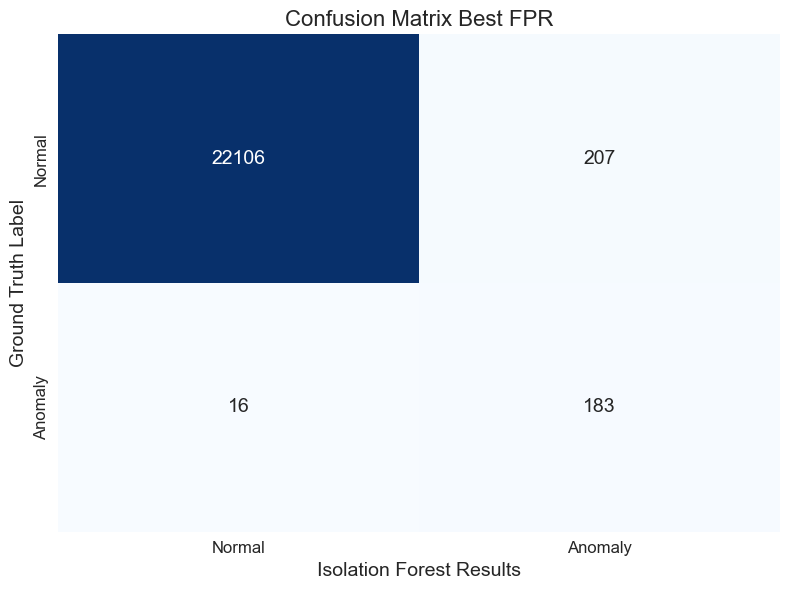

False Positive Rate: 0.93%
False Negative Rate: 8.04%


In [31]:
conf_matrix = conf_matrix_fpr
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# Set seaborn style
sns.set_style("whitegrid")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix Best FPR', fontsize=16)
plt.xlabel('Isolation Forest Results', fontsize=14)
plt.ylabel('Ground Truth Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# Print false positive and false negative rates
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")

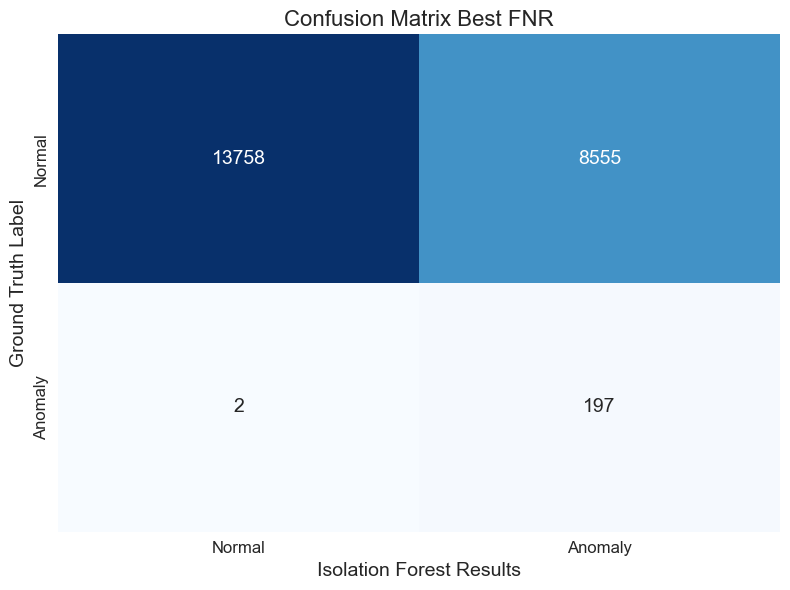

False Positive Rate: 38.34%
False Negative Rate: 1.01%


In [29]:
conf_matrix = conf_matrix_fnr
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# Set seaborn style
sns.set_style("whitegrid")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix Best FNR', fontsize=16)
plt.xlabel('Isolation Forest Results', fontsize=14)
plt.ylabel('Ground Truth Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# Print false positive and false negative rates
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")

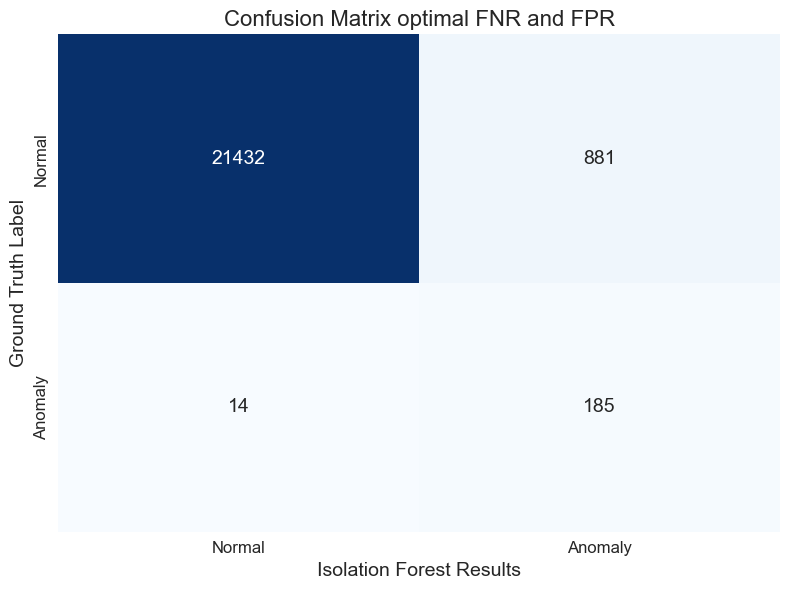

False Positive Rate: 3.95%
False Negative Rate: 7.04%


In [30]:
conf_matrix = conf_matrix_combined
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
false_negative_rate = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# Set seaborn style
sns.set_style("whitegrid")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix optimal FNR and FPR', fontsize=16)
plt.xlabel('Isolation Forest Results', fontsize=14)
plt.ylabel('Ground Truth Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
# Print false positive and false negative rates
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")

### RUNNING FOR COMPLEX DATA

In [33]:
# Define folder path
folder_path = "labelled_data_electrolux/"
results_df = pd.DataFrame(columns=['File', 'Best Parameters', 'Best Score'])
# Iterate over files in the folder
combined_df = combine_dataframes(folder_path)
# Load ground truth DataFrame
combined_df = combined_df[['shot_time', 'COUNTER_ID', 'cycle_time', 'GT_Anomaly']]
# ground_truth = ground_truth[['shot_time', 'COUNTER_ID', 'cycle_time', 'value2']]
combined_df.rename(columns={'GT_Anomaly': 'ground_truth'}, inplace=True)
combined_df['ground_truth'] = combined_df['ground_truth'].replace('`1', '1')
combined_df['ground_truth'] = combined_df['ground_truth'].astype(int)
# combined_df['ground_truth'] = 1 - combined_df['ground_truth'] # Inverting it for clarity 1 means anomaly and 0 means normal (1 is positive class and 0 is negative class)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_samples': ['auto',0.1,0.2,0.3,0.4,0.5],
    'contamination': ['auto', 0.1,0.2,0.3,0.4,0.5],
    'max_features': [1.0,0.1,0.2,0.3,0.4,0.5],
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

# param
best_params_fpr = None
best_params_fnr = None
best_params_fnr_combined = None

# score
best_score_fnr =  float('inf')
best_score_fpr =  float('inf')
best_score_fnr_combined =  float('inf')
best_score_fpr_combined =  float('inf')

# confusion metrix
conf_matrix_fnr =  None
conf_matrix_fpr =  None
conf_matrix_combined =  None

total_iterations = len(list(ParameterGrid(param_grid)))
with tqdm(total=total_iterations, desc="Hyperparameter Tuning") as pbar:
    for params in ParameterGrid(param_grid):
        # Create Isolation Forest model
        if_model = IsolationForest(**params, random_state=12)
        data = ['cycle_time']
        # Fit model
        if_model.fit(combined_df[data])

        # Calculate anomaly scores
        combined_df['anomaly_score'] = if_model.decision_function(combined_df[data])
        combined_df['anomaly_score_inverse'] = if_model.score_samples(combined_df[data])

        # Predict anomalies
        combined_df[f'output'] = if_model.predict(combined_df[data])
        combined_df[f'output'] = combined_df[f'output'].apply(lambda x: 0 if x == -1 else 1)
        combined_df[f'output'] = 1 - combined_df[f'output'] # Inverting it for clarity 1 means anomaly and 0 means normal (1 is positive class and 0 is negative class)

        # Compare results with ground truth
        fpr,fnr, cm = compare_with_ground_truth(combined_df[f'output'], combined_df['ground_truth'])

        # Update best parameters if necessary
        if fpr < best_score_fpr:
            best_params_fpr = params
            conf_matrix_fpr = cm
            best_score_fpr =fpr
        
        if fnr < best_score_fnr:
            best_params_fnr = params
            conf_matrix_fnr = cm
            best_score_fnr = fnr


        if fpr < best_score_fpr_combined and fnr < best_score_fnr_combined:
            best_score_fpr = fpr
            best_score_fnr = fnr
            best_params_fnr_combined = params
            conf_matrix_combined = cm
            best_score_fnr_combined = fnr
            best_score_fpr_combined = fpr

        pbar.update(1)  # Update progress bar
# Print all best parameters and scores
print("Best parameters for FPR:", best_params_fpr)
print("Best score FPR:", best_score_fpr)
print("Confusion Matrix FPR:", conf_matrix_fpr)

print("Best parameters for FNR:", best_params_fnr)
print("Best score FNR:", best_score_fnr)
print("Confusion Matrix FNR:", conf_matrix_fnr)

print("Best parameters for Combined FPR and FNR:", best_params_fnr_combined)
print("Best score Combined FPR:", best_score_fnr_combined)
print("Best score Combined FPR:", best_score_fpr_combined)
print("Confusion Matrix Combined:", conf_matrix_combined)

Hyperparameter Tuning:  61%|██████    | 2617/4320 [3:48:27<4:08:13,  8.75s/it]

In [ ]:
# # Define folder path
# folder_path = "Labelled_Data/"
# results_df = pd.DataFrame(columns=['File', 'Best Parameters', 'Best Score'])
# # Iterate over files in the folder
# for file_name in os.listdir(folder_path):
#     if file_name.endswith(".csv"):
#         # Load data from file
#         file_path = os.path.join(folder_path, file_name)
#         combined_df = pd.read_csv(file_path)

#         # Load ground truth DataFrame
#         ground_truth = pd.read_csv(file_path)  # Update with your ground truth file path
#         ground_truth = ground_truth[['shot_time', 'COUNTER_ID', 'cycle_time', 'value2']]
#         ground_truth.rename(columns={'value2': 'ground_truth'}, inplace=True)
#         ground_truth['ground_truth'] = ground_truth['ground_truth'].apply(lambda x: 0 if x == 2 else 1)
#         ground_truth['ground_truth'] = 1 - ground_truth['ground_truth'] # Inverting it for clarity 1 means anomaly and 0 means normal (1 is positive class and 0 is negative class)

#         # Define parameter grid
#         param_grid = {
#             'n_estimators': [50, 100, 150, 200],
#             'max_samples': ['auto',0.1,0.2,0.3,0.4,0.5],
#             'contamination': ['auto', 0.1,0.2,0.3,0.4,0.5],
#             'max_features': [1.0,0.1,0.2,0.3,0.4,0.5],
#             'bootstrap': [True, False],
#             'warm_start': [True, False]
#         }
#         # Iterate over parameter grid
#         best_score = 100
#         best_params = None
#         for params in ParameterGrid(param_grid):
#             # Create Isolation Forest model
#             if_model = IsolationForest(**params, random_state=12)
#             data = ['cycle_time']
#             # Fit model
#             if_model.fit(combined_df[data])

#             # Calculate anomaly scores
#             combined_df['anomaly_score'] = if_model.decision_function(combined_df[data])
#             combined_df['anomaly_score_inverse'] = if_model.score_samples(combined_df[data])

#             # Predict anomalies
#             combined_df[f'output_{params["contamination"]}'] = if_model.predict(combined_df[data])
#             combined_df[f'output_{params["contamination"]}'] = combined_df[f'output_{params["contamination"]}'].apply(lambda x: 0 if x == -1 else 1)
#             combined_df[f'output_{params["contamination"]}'] = 1 - combined_df[f'output_{params["contamination"]}'] # Inverting it for clarity 1 means anomaly and 0 means normal (1 is positive class and 0 is negative class)

#             # Compare results with ground truth
#             score, cm = compare_with_ground_truth(combined_df[f'output_{params["contamination"]}'], ground_truth['ground_truth'])

#             # Update best parameters if necessary
#             if score > best_score:
#                 best_score = score
#                 best_params = params
#                 conf_matrix = cm
#         # Store best parameters and score in DataFrame
#         results_df = results_df.append({'File': file_name, 'Best Parameters': best_params, 'Best Score': best_score}, ignore_index=True)
#         print("File:", file_name)
#         print("Best parameters:", best_params)
#         print("Best score:", best_score)
#         print("Confusion Matrix:", conf_matrix)